In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import OoT_fix.oot as oot
import scipy.misc as sMisc
from astropy.stats import LombScargle
import pylanet.data as pydata
import pylanet.model as pymodel
import pylanet.plot as pyplot

import astropy.units as u
import astropy
import astroquery

import SEDBuilder.SEDBuilder as SEDBuilder
import extinction

import emcee
import corner
import splitnormal.splitnormal as split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='white'
mpl.rcParams['axes.linewidth']=2

mpl.rcParams['text.color'] = 'dimgrey'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=14
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

mpl.rcParams["text.usetex"] = True

In [14]:
def sigString(number,significantFigures,extra=False): # returns a number to a given significant digits (if extra is true also returns base of first significant figure)
    roundingFactor=significantFigures - int(np.floor(np.log10(np.abs(number)))) - 1
    rounded=np.round(number, roundingFactor)
    # np.round retains a decimal point even if the number is an integer (i.e. we might expect 460 but instead get 460.0)
    if roundingFactor<=0:
        rounded=rounded.astype(int)
    string=rounded.astype(str)
    if extra==False:
        return string
    if extra==True:
        return string,roundingFactor
    
print(sigString(4567.89,3,extra=True))

('4570', -1)


In [80]:
import scipy.integrate
h=6.63e-34
k=1.38e-23
c=3e8
sigmal=5.67e-8
lSun=3.83e26
pc=3.09e16

def bLambda(l,T): # single temp blackbody
    return 2*h*np.power(c,2)*np.power(l,-5)/(np.exp(h*c/(l*k*T))-1)
'''def integrand(eps,beta): # integrand for disk blackbody
    return ((eps)**3)/(np.exp(beta*eps)-1)
def dLambda(ls,T0,T1,Te=-1): # blackbody of disk
    fluxs=np.zeros_like(ls)
    for i,l in enumerate(ls):
        beta=h*c/(k*l*T0)
        eps0=1
        if Te!=-1:
            eps0=T0/Te
        integral=scipy.integrate.quad(integrand,eps0,T0/T1,args=(beta))[0]
        fluxs[i]=2*h*np.power(c,2)*np.power(l,-5)*integral
    return fluxs
def simpleDisk(ls,T0,T1,mu):
    return bLambda(ls,T0)+mu*dLambda(ls,T0,T1)'''
def oneBlackbody(ls,T0,L0,a_v):
    R0=np.sqrt((L0*lSun)/(4*np.pi*sigmal*np.power(T0,4))) # in m
    D=(1000/2.9031)*pc # in m
    R0_D=R0/D
    oneBlackbod=(R0_D**2)*bLambda(ls,T0)
    return extinction.apply(extinction.fm07(1e10*ls.astype(np.float),a_v),np.pi*oneBlackbod)
def twoBlackbody(ls,T0,T1,L0,L1,a_v):
    R0=np.sqrt((L0*lSun)/(4*np.pi*sigmal*np.power(T0,4))) # in m
    R1=np.sqrt((L1*lSun)/(4*np.pi*sigmal*np.power(T1,4))) # in m
    D=(1000/2.9031)*pc # in m
    R0_D=R0/D
    R1_D=R1/D
    twoBlackbodys=(R0_D**2)*bLambda(ls,T0) + (R1_D**2)*bLambda(ls,T1)
    return extinction.apply(extinction.fm07(1e10*ls.astype(np.float),a_v),np.pi*twoBlackbodys)

def findResiduals(model,vals,errs):
    rs=(model-vals)/errs
    limits=np.flatnonzero(errs==0)
    aboveLimits=np.flatnonzero((errs==0) & ((model-vals)>0))
    rs[limits]=0 #if it's below the limit it's fine
    rs[aboveLimits]=(model[aboveLimits]-vals[aboveLimits])/(vals[aboveLimits]/12) #if above, severely penalise with overly small error
    return rs

In [81]:
table=SEDBuilder.getSED(name='HAT-P-7')
print(table)

    lambda         flux         error              source         telescope
------------- ------------- ------------- ----------------------- ---------
3.6345133e-07 1.9894492e-06 2.2710605e-09            Greiss+ 2012       INT
 4.205922e-07  2.509924e-06           0.0               Men+ 2016 Hipparcos
 4.205922e-07 2.6116777e-06  1.526305e-07                ESA 1997 Hipparcos
 4.205922e-07  2.526883e-06 1.3567157e-07               Ofek 2008 Hipparcos
 4.205922e-07  2.526883e-06           0.0             Urban+ 2001 Hipparcos
 4.205922e-07  2.509924e-06 1.3567157e-07           Stevens+ 2017 Hipparcos
 4.205922e-07  2.509924e-06 1.3567157e-07            Ammons+ 2006 Hipparcos
 4.205922e-07  2.509924e-06 1.3567157e-07 Gaia Collaboration 2016 Hipparcos
 4.445103e-07  2.717757e-06 1.8219602e-07              STScI 2006     2MASS
 4.445103e-07  2.459646e-06           0.0        Nascimbeni+ 2016     2MASS
          ...           ...           ...                     ...       ...
4.6032037e-0

telescope 
----------
     2MASS
      Gaia
 Hipparcos
       INT
Pan-STARRS
      SDSS
   Spitzer
    Subaru
      WISE


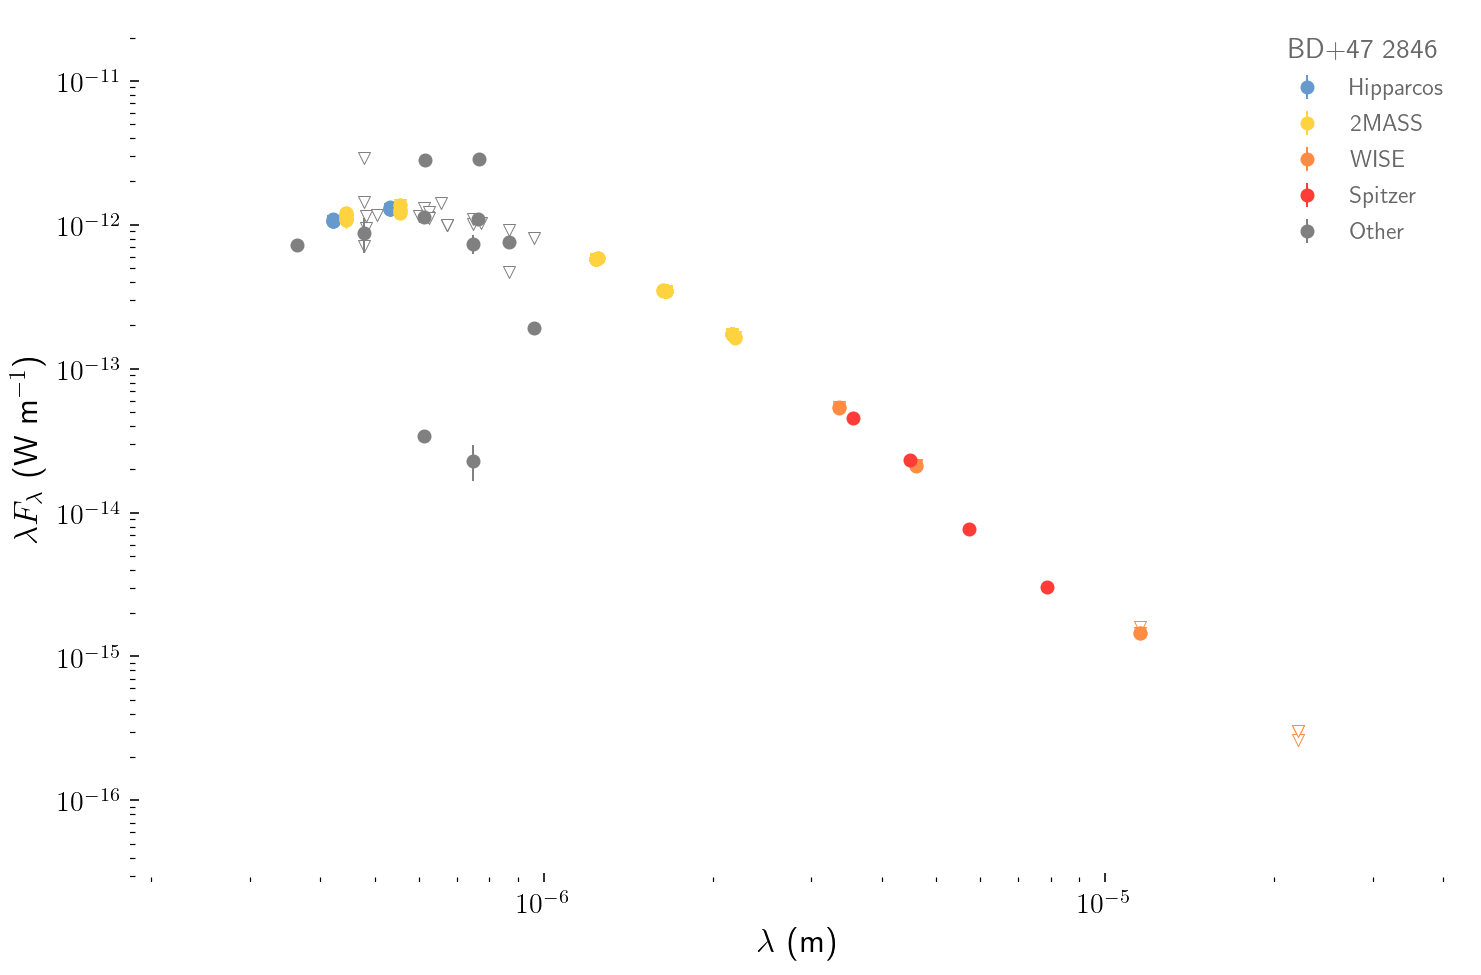

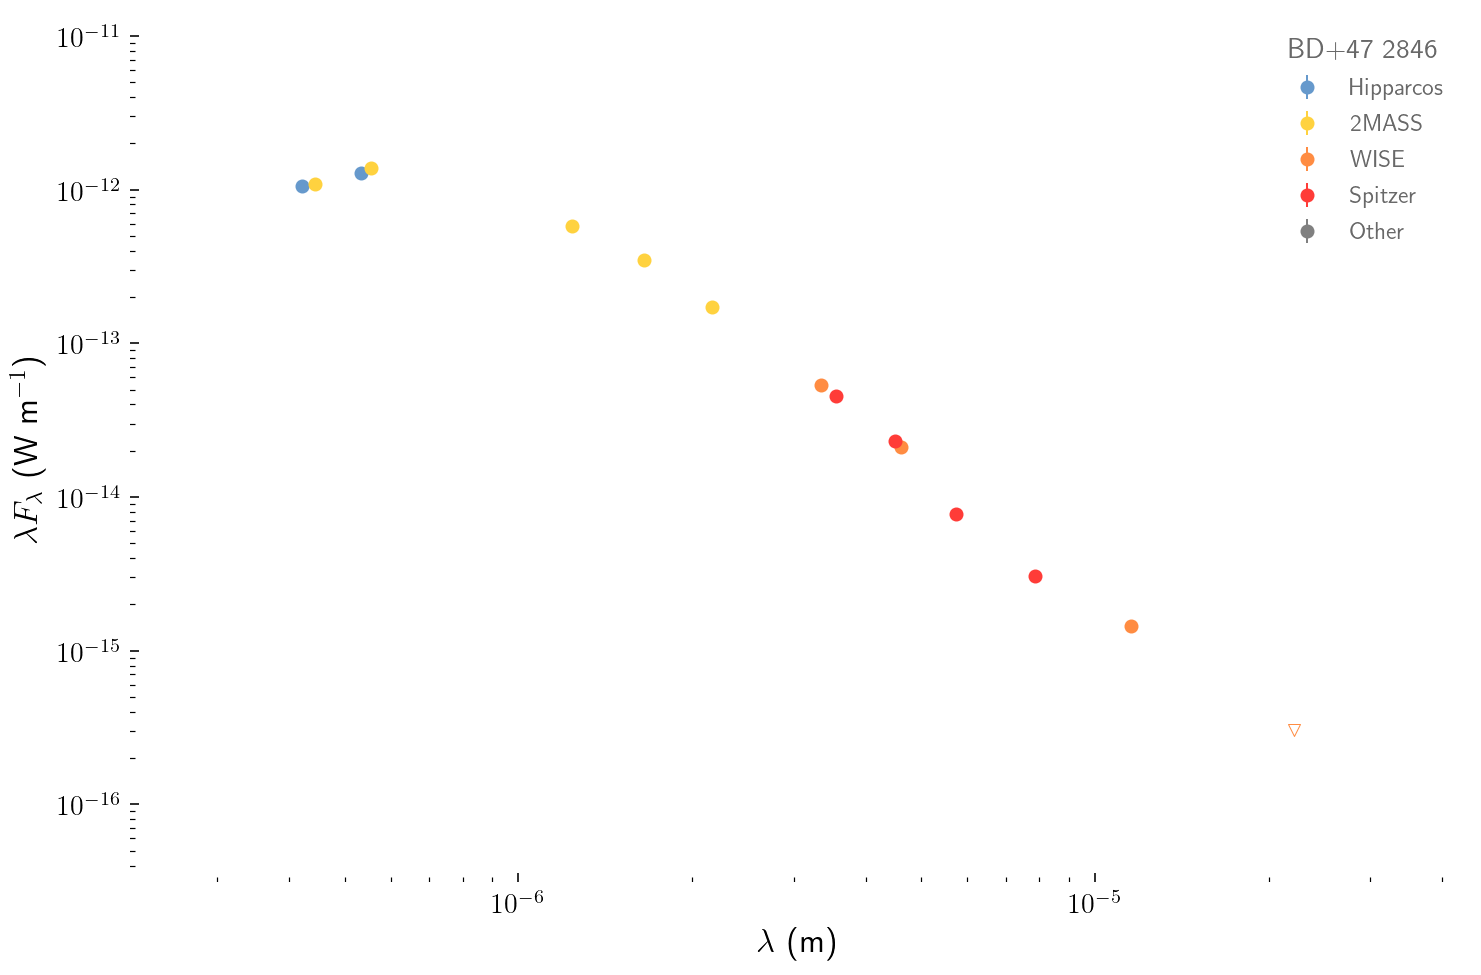

In [115]:
print(np.unique(table['telescope']))
tels=['Hipparcos','2MASS','WISE','Spitzer']

sedFig=plt.figure(figsize=(12,8))
sedPlot=plt.gca()
SEDBuilder.plotSED(sedPlot,table,telescopes=tels)
plt.show()

cleanFig=plt.figure(figsize=(12,8))
cleanPlot=plt.gca()
cleanTable=SEDBuilder.cleanData(table,telescopes=tels)
#goodData=np.flatnonzero((cleanTable['telescope']!='INT') | (cleanTable['lambda']<4e-7)) # some dodgy INT points but the lowest wavelength one is useful
#print(np.flatnonzero(cleanTable['telescope']!='INT'))
#cleanTable=cleanTable[goodData]
#cleanTable=cleanTable
SEDBuilder.plotSED(cleanPlot,cleanTable,telescopes=tels)
plt.show()

In [157]:
import emcee

def mapXs(x): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
    newX[:,0]=3+3*newX[:,0] #log(T0)
    newX[:,1]=3*newX[:,1] #log(T1)
    newX[:,2]=8*newX[:,2] #log(L0)
    newX[:,3]=-8+8*newX[:,3] #log(L1)
    newX[:,4]=7*newX[:,4] #Av
    newX[:,5]=-1.5+1*newX[:,5] #sigma factor
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def lnprob(x,ls,fs,es):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapXs(x) # maps them to appropriate parameter values
    
    logLs=np.log10(ls)
    logFs=np.log10(fs)
    
    # Increasing the error by a multiplicative factor of the flux (i.e. assume all measurements are 5% innacurate)
    sigmaFactor=10**x[5]
    
    logEs=np.zeros_like(logLs)
    sigmas=np.sqrt((es**2 + (sigmaFactor*fs)**2))
    #print(sigmas)
    logEs[es>0]=np.log10(fs[es>0]+sigmas[es>0])-np.log10(fs[es>0])
    
    T0=10**x[0] # in K
    T1=10**x[1] # in K
    L0=10**x[2] # in Lsun
    L1=10**x[3] # in Lsun
    Av=x[4]
    model=twoBlackbody(ls,T0,T1,L0,L1,Av)
    #print(model)
    residual=findResiduals(np.log10(model),logFs,logEs)**2
    
    # Below taken from Emcee's Fitting a Model to Data - assuming error unreliable
    #sigmaFactor=10**x[5]
    #sigmaCorrect=(logEs**2)/(logEs**2 + (sigmaFactor**2)*(np.log10(model)**2))
    ##sigmaCorrect=(logEs**2)/((sigmaFactor**2)*(logEs**2))
    ##sigmaCorrect[logEs==0]=0
    ##residual=residual*sigmaCorrect
    ##residual[logEs>0]= residual[logEs>0] + np.log(2*np.pi*(logEs[logEs>0]**2)*(sigmaFactor**2))
    #residual[logEs>0]= residual[logEs>0] + np.log(2*np.pi*(logEs[logEs>0]**2)/sigmaCorrect[logEs>0])
    #print(-(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior)
    '''quickPlot=plt.gca()
    quickPlot.plot(ls,ls*model)
    quickPlot.scatter(ls,ls*fs)
    quickPlot.set_title(str(-(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior))
    quickPlot.set_ylabel(str(L0))
    quickPlot.set_xlabel(str(T0))
    
    quickPlot.set_xscale('log')
    quickPlot.set_yscale('log')
    
    plt.show()'''
    
    #print(residual)
    return -(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior # finds the best chi2 test fit

es=cleanTable['error']
ls=cleanTable['lambda']
fs=cleanTable['flux']
#es=es[es>0]


ndim, nwalkers = 6,128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
#p0[:,0]=0.5*np.pi*p0[:,0]
#p0[:,1]=np.pi*p0[:,1]
#p0[:,3]=10*p0[:,3]

nSteps = 512
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ls,fs,es])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


$T_0 \ [K]$
(5.955777045404773, 1.03339456585711, 0.029152817098758277)
$T_1 \ [K]$
(0.06878422381482364, 0.0447035013861712, 1.7976935888525694)
$L_0 \ [L_\odot]$
(7.135005918959809, 3.1415633744592846, 0.051586764053368483)
$L_1 \ [L_1]$
(-7.7909539082538455, 0.17498734243497616, 4.587926017833863)
$A_v$
(2.543244326272413, 0.24874962558766445, 0.0303798375334261)
$\sigma$
(-0.8780180160318454, 0.09111885491128491, 0.1440563312879981)


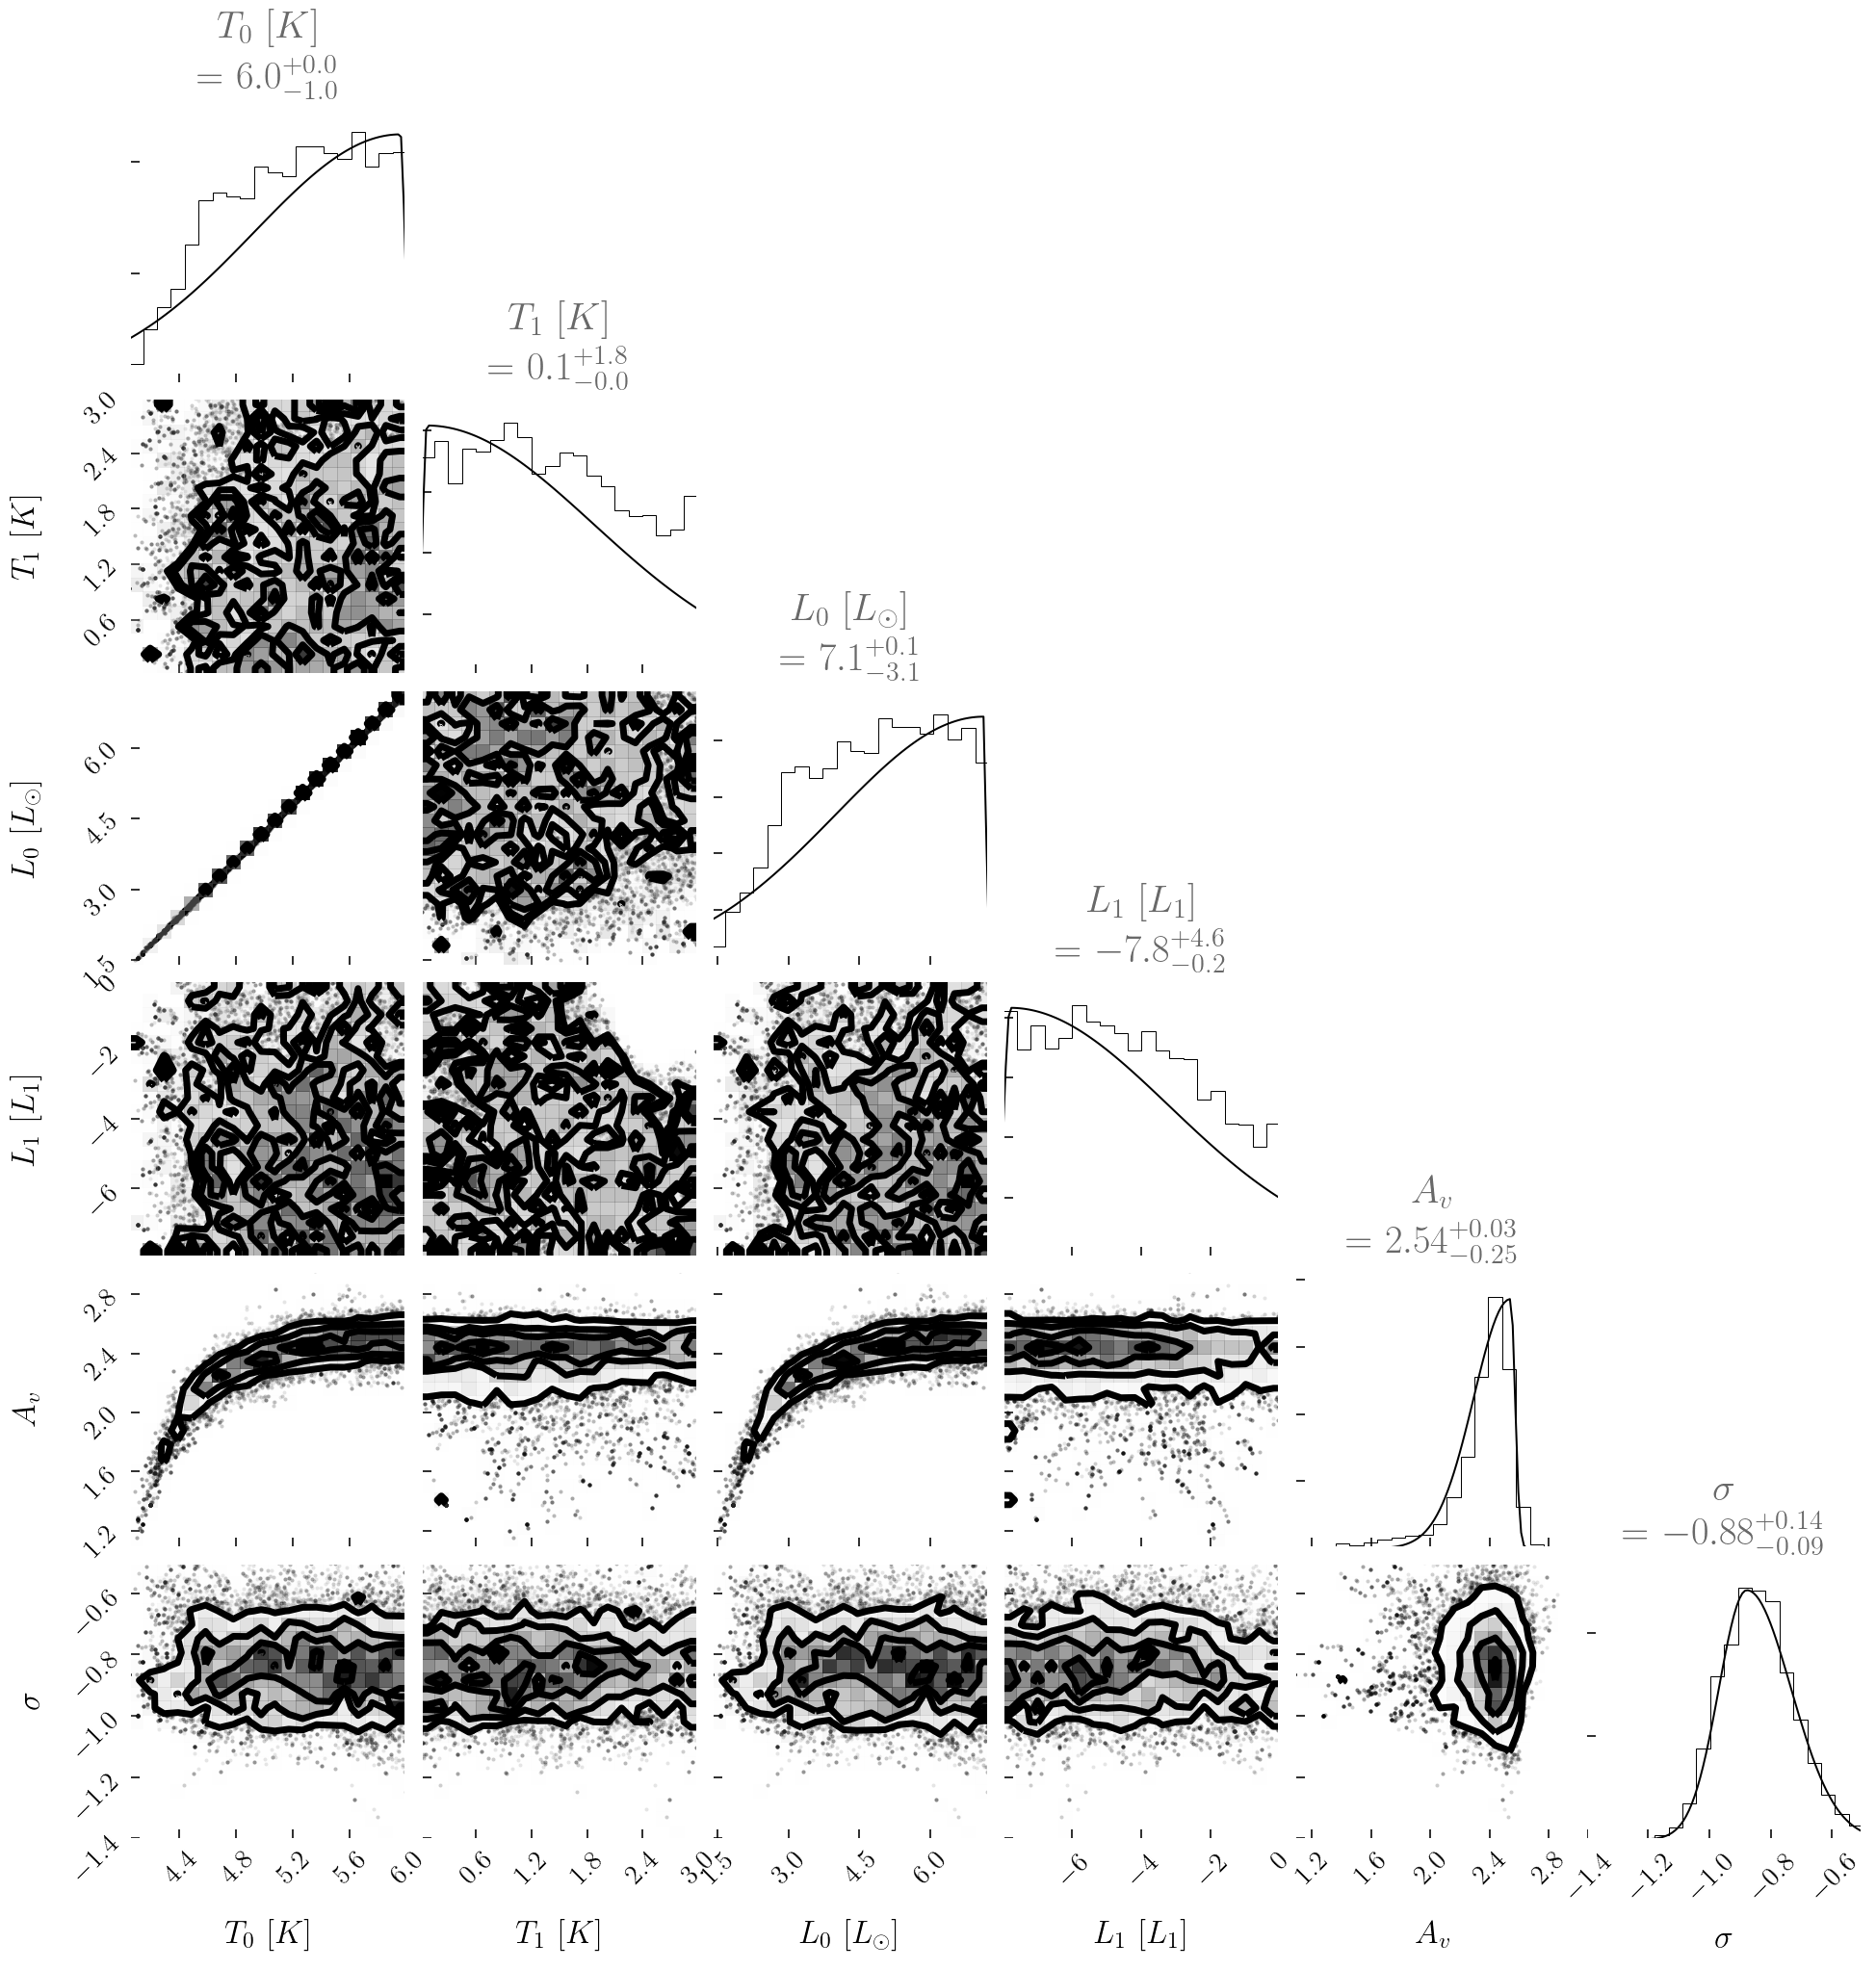

In [158]:
samples = sampler.chain[:,int(nSteps/2):,:].reshape((-1, ndim))

#truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.155),np.log10(0.006),0.2,0,0.5,0,0]
labels=[r'$T_0 \ [K]$',r'$T_1 \ [K]$',r'$L_0 \ [L_\odot]$',r'$L_1 \ [L_1]$',r'$A_v$',r'$\sigma$']
mapped=mapXs(samples)
for i in range(ndim):
    print(labels[i])
    print(split.fit(mapped[:,i]))
fig = corner.corner(mapped,labels=labels,range=1.0*np.ones(ndim))
axes = np.array(fig.axes).reshape((ndim, ndim))
# Loop over the diagonal
for i in range(ndim):
    mu,sigma,cigma=split.fit(mapped[:,i])
    ax = axes[i, i]
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotXs=np.linspace(xlim[0],xlim[1],100)
    norm=0.9*ylim[1]/split.splitNormal(np.array([mu]),mu,sigma,cigma)
    ax.plot(plotXs,norm*split.splitNormal(plotXs,mu,sigma,cigma),c='k',lw=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
    cigmaString,cigmaDec=sigString(cigma,2,extra=True)
    sigmaString,sigmaDec=sigString(sigma,2,extra=True)
    muSigFigs=np.min([cigmaDec,sigmaDec])
    muString=np.round(mu,muSigFigs)
    if muSigFigs<=0:
        muSigFigs=int(muSigFigs)
    cigmaString = "+{0}".format(np.round(cigma,muSigFigs))
    sigmaString = "-{0}".format(np.round(sigma,muSigFigs))
    titleString = r"{0}".format(labels[i])+"\n = ${"+str(muString)+"}^{"+cigmaString+"}_{"+sigmaString+"}$"
    ax.set_title(titleString)
    
plt.show()

bestProb:  33.3119406076329
bestMap:  [ 5.43747344  2.20856193  5.53500882 -2.6970136   2.47773407 -0.93928136]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TableReplaceWarning: replaced column 'error' which looks like an array slice. The new column no longer shares memory with the original array.


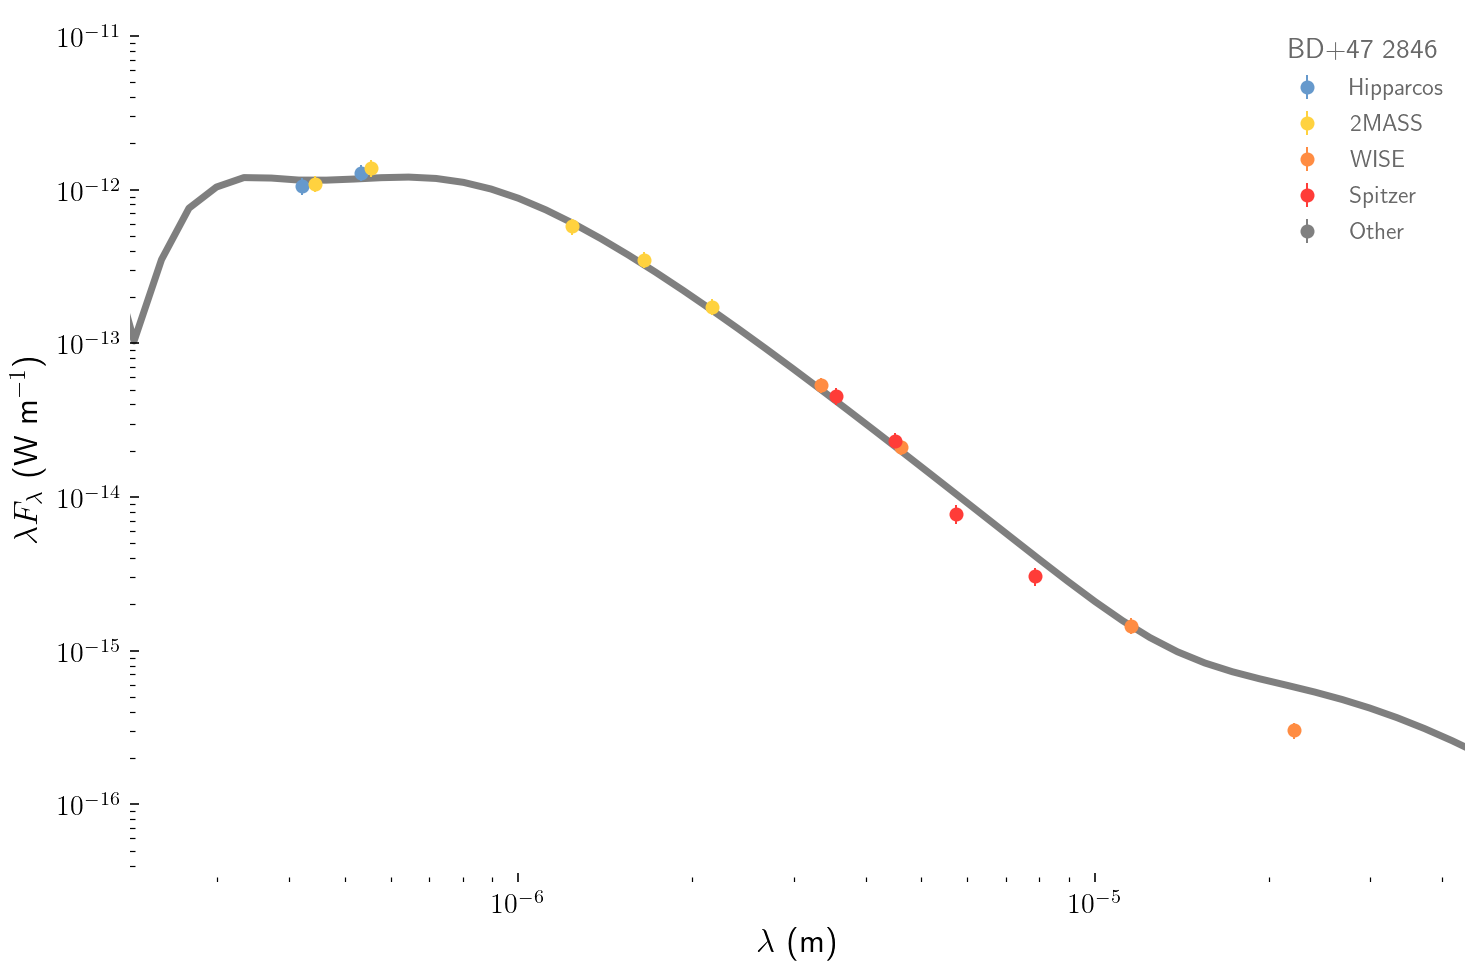

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TableReplaceWarning: replaced column 'error' which looks like an array slice. The new column no longer shares memory with the original array.


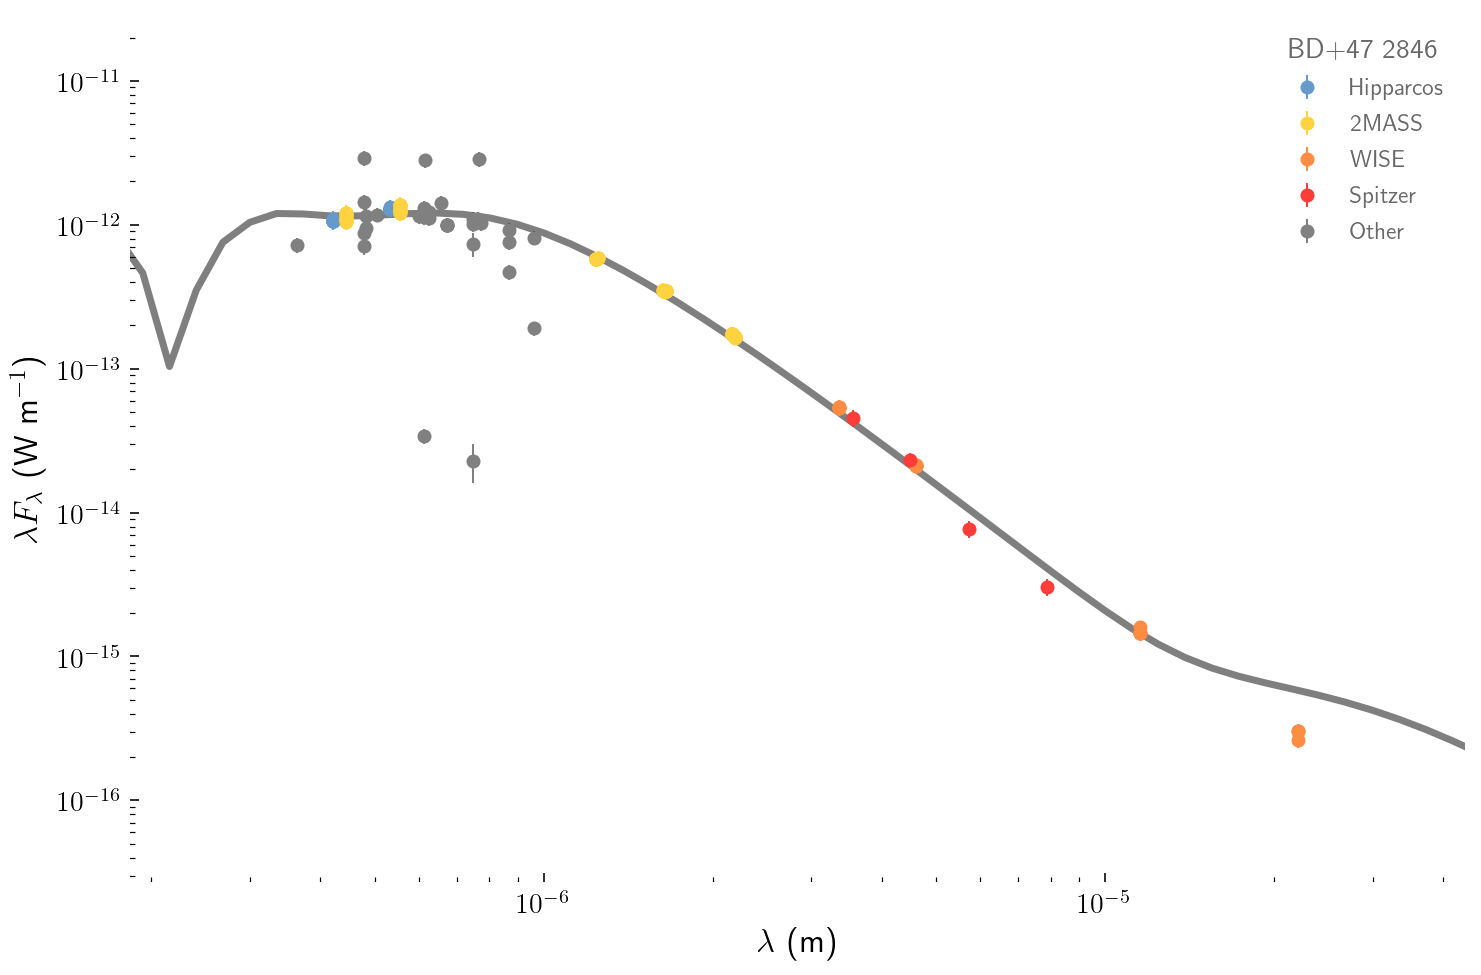

In [159]:
bestProb=np.max(sampler.lnprobability)
print('bestProb: ',bestProb)
bestStep=np.argmax(sampler.lnprobability)
bestX=sampler.chain.reshape((-1, ndim))[bestStep,:]
bestMap=mapXs(bestX)
print('bestMap: ',bestMap)

T0=10**bestMap[0]
T1=10**bestMap[1]
L0=10**bestMap[2]
L1=10**bestMap[3]
Av=bestMap[4]
sigmaFactor=10**bestMap[5]

modelLs=10**np.linspace(-7,-4,64)
modelFs=twoBlackbody(modelLs,T0,T1,L0,L1,Av)

cleanFig=plt.figure(figsize=(12,8))
cleanPlot=plt.gca()
newClean=cleanTable[:]
newClean['error']=np.sqrt((newClean['error']**2 + (sigmaFactor*newClean['flux'])**2))
SEDBuilder.plotSED(cleanPlot,newClean,telescopes=tels)
cleanPlot.plot(modelLs,modelLs*modelFs,c='k',alpha=0.5)
plt.show()

sedFig=plt.figure(figsize=(12,8))
sedPlot=plt.gca()
newSED=table[:]
newSED['error']=np.sqrt((newSED['error']**2 + (sigmaFactor*newSED['flux'])**2))
SEDBuilder.plotSED(sedPlot,newSED,telescopes=tels)
sedPlot.plot(modelLs,modelLs*modelFs,c='k',alpha=0.5)
plt.show()

# Fitting a single blackbody to the low wavelength data

Below 3 um

In [154]:
reducedData=np.flatnonzero(cleanTable['lambda']<3e-6)
redTable=cleanTable[reducedData]

def mapXs(x): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
    newX[:,0]=2+4*newX[:,0] #log(T0)
    newX[:,1]=-2+7*newX[:,1] #log(L0)
    newX[:,2]=7*newX[:,2] #Av
    newX[:,3]=-3+3*newX[:,3] #sigma factor
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def lnprob(x,ls,fs,es):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapXs(x) # maps them to appropriate parameter values
    
    logLs=np.log10(ls)
    logFs=np.log10(fs)
    
    # Increasing the error by a multiplicative factor of the flux (i.e. assume all measurements are 5% innacurate)
    sigmaFactor=10**x[3]
    
    logEs=np.zeros_like(logLs)
    sigmas=np.sqrt((es**2 + (sigmaFactor*fs)**2))
    #print(sigmas)
    logEs[es>0]=np.log10(fs[es>0]+sigmas[es>0])-np.log10(fs[es>0])
    
    T0=10**x[0] # in K
    L0=10**x[1] # in Lsun
    Av=x[2]
    model=oneBlackbody(ls,T0,L0,Av)
    #print(model)
    residual=findResiduals(np.log10(model),logFs,logEs)**2
    
    # Below taken from Emcee's Fitting a Model to Data - assuming error unreliable
    #sigmaFactor=10**x[5]
    #sigmaCorrect=(logEs**2)/(logEs**2 + (sigmaFactor**2)*(np.log10(model)**2))
    ##sigmaCorrect=(logEs**2)/((sigmaFactor**2)*(logEs**2))
    ##sigmaCorrect[logEs==0]=0
    ##residual=residual*sigmaCorrect
    ##residual[logEs>0]= residual[logEs>0] + np.log(2*np.pi*(logEs[logEs>0]**2)*(sigmaFactor**2))
    #residual[logEs>0]= residual[logEs>0] + np.log(2*np.pi*(logEs[logEs>0]**2)/sigmaCorrect[logEs>0])
    #print(-(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior)
    '''quickPlot=plt.gca()
    quickPlot.plot(ls,ls*model)
    quickPlot.scatter(ls,ls*fs)
    quickPlot.set_title(str(-(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior))
    quickPlot.set_ylabel(str(L0))
    quickPlot.set_xlabel(str(T0))
    
    quickPlot.set_xscale('log')
    quickPlot.set_yscale('log')
    
    plt.show()'''
    
    #print(residual)
    return -(np.sum(residual)/2) - np.sum(np.log(logEs[es>0]**2))/2 + prior # finds the best chi2 test fit

es=redTable['error']
ls=redTable['lambda']
fs=redTable['flux']
#es=es[es>0]


ndim, nwalkers = 4,128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
#p0[:,0]=0.5*np.pi*p0[:,0]
#p0[:,1]=np.pi*p0[:,1]
#p0[:,3]=10*p0[:,3]

nSteps = 512
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ls,fs,es])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


$T_0 \ [K]$
(4.1177930309093345, 0.25738656325793263, 0.47371927733209596)
$L_0 \ [L_\odot]$
(1.1764737912158818, 0.21358757851971255, 1.858255812543339)
$A_v$
(2.4955777932825396, 1.1337142704921035, 0.06485107612472696)
$\sigma$
(-0.9652612166776646, 0.41366512840361036, 0.09013287910669154)


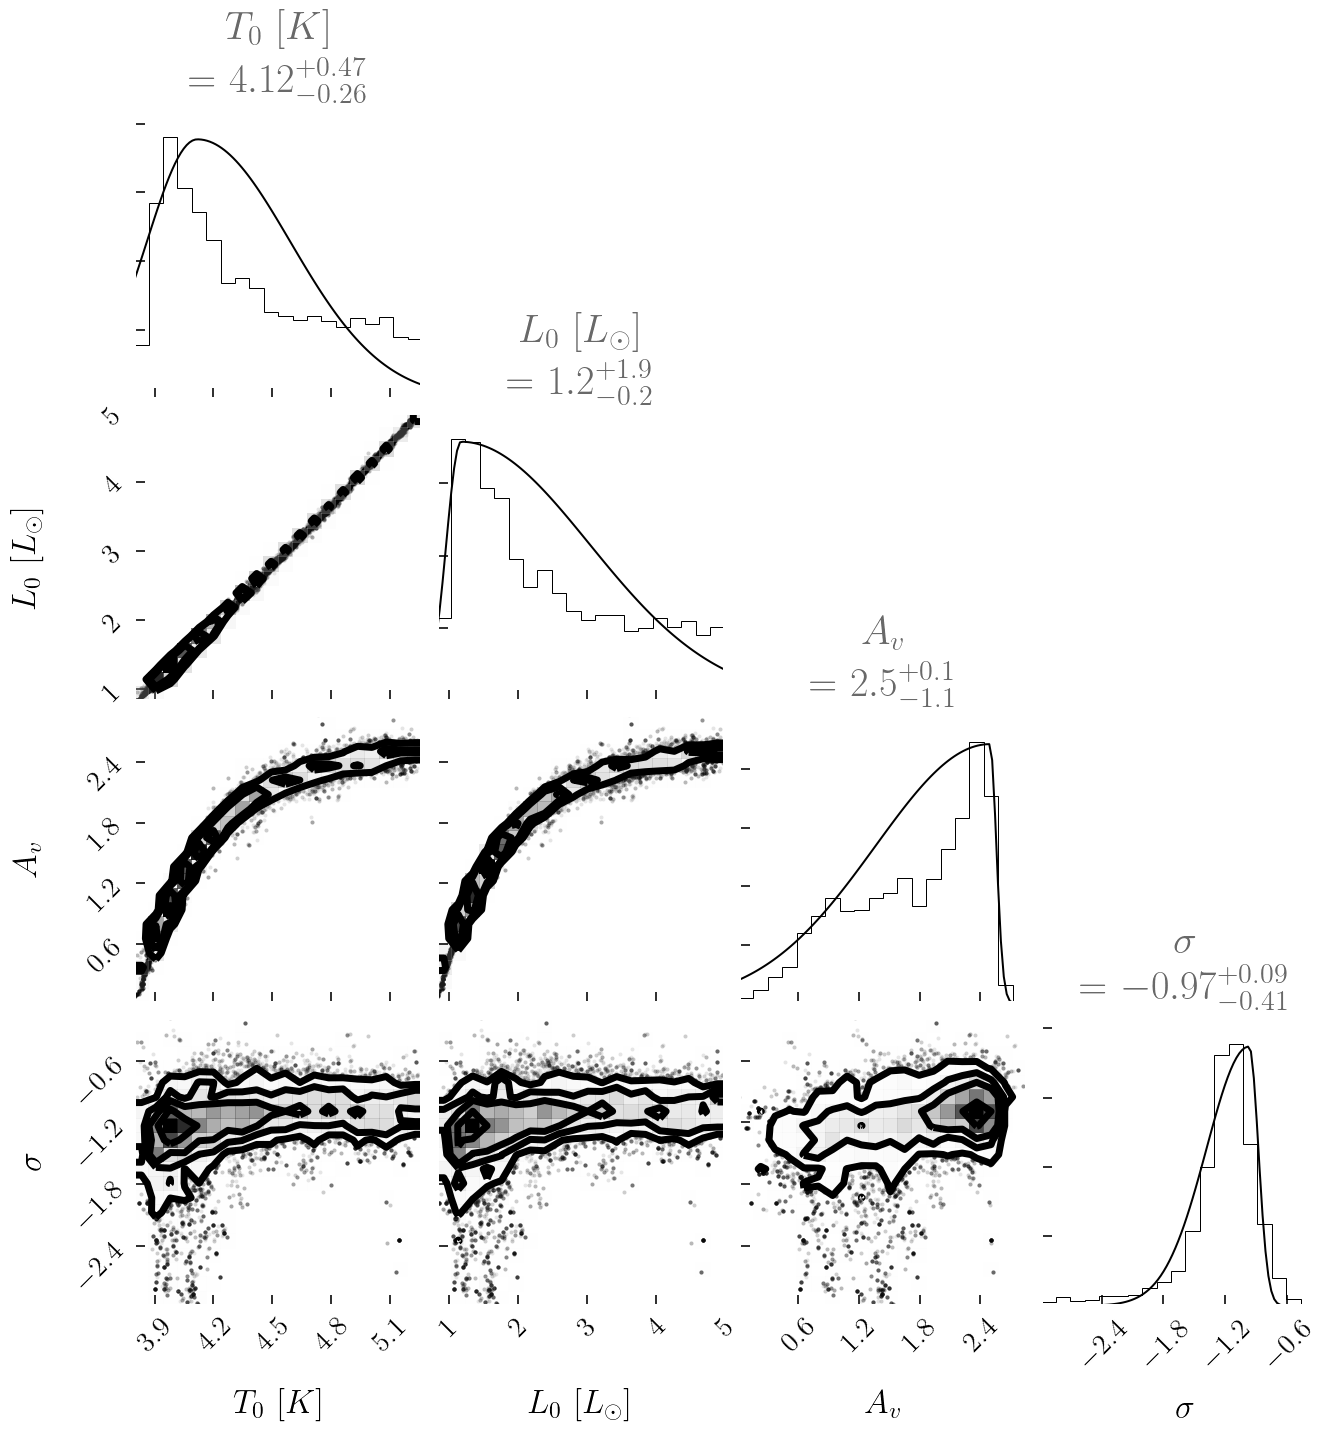

In [155]:
samples = sampler.chain[:,int(nSteps/2):,:].reshape((-1, ndim))

#truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.155),np.log10(0.006),0.2,0,0.5,0,0]
labels=[r'$T_0 \ [K]$',r'$L_0 \ [L_\odot]$',r'$A_v$',r'$\sigma$']
mapped=mapXs(samples)
for i in range(ndim):
    print(labels[i])
    print(split.fit(mapped[:,i]))
fig = corner.corner(mapped,labels=labels,range=1.0*np.ones(ndim))
axes = np.array(fig.axes).reshape((ndim, ndim))
# Loop over the diagonal
for i in range(ndim):
    mu,sigma,cigma=split.fit(mapped[:,i])
    ax = axes[i, i]
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotXs=np.linspace(xlim[0],xlim[1],100)
    norm=0.9*ylim[1]/split.splitNormal(np.array([mu]),mu,sigma,cigma)
    ax.plot(plotXs,norm*split.splitNormal(plotXs,mu,sigma,cigma),c='k',lw=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
    cigmaString,cigmaDec=sigString(cigma,2,extra=True)
    sigmaString,sigmaDec=sigString(sigma,2,extra=True)
    muSigFigs=np.min([cigmaDec,sigmaDec])
    muString=np.round(mu,muSigFigs)
    if muSigFigs<=0:
        muSigFigs=int(muSigFigs)
    cigmaString = "+{0}".format(np.round(cigma,muSigFigs))
    sigmaString = "-{0}".format(np.round(sigma,muSigFigs))
    titleString = r"{0}".format(labels[i])+"\n = ${"+str(muString)+"}^{"+cigmaString+"}_{"+sigmaString+"}$"
    ax.set_title(titleString)
    
plt.show()

bestProb:  25.068519333669133
bestMap:  [ 3.83762785  0.91198984  0.25261942 -1.69611766]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TableReplaceWarning: replaced column 'error' which looks like an array slice. The new column no longer shares memory with the original array.


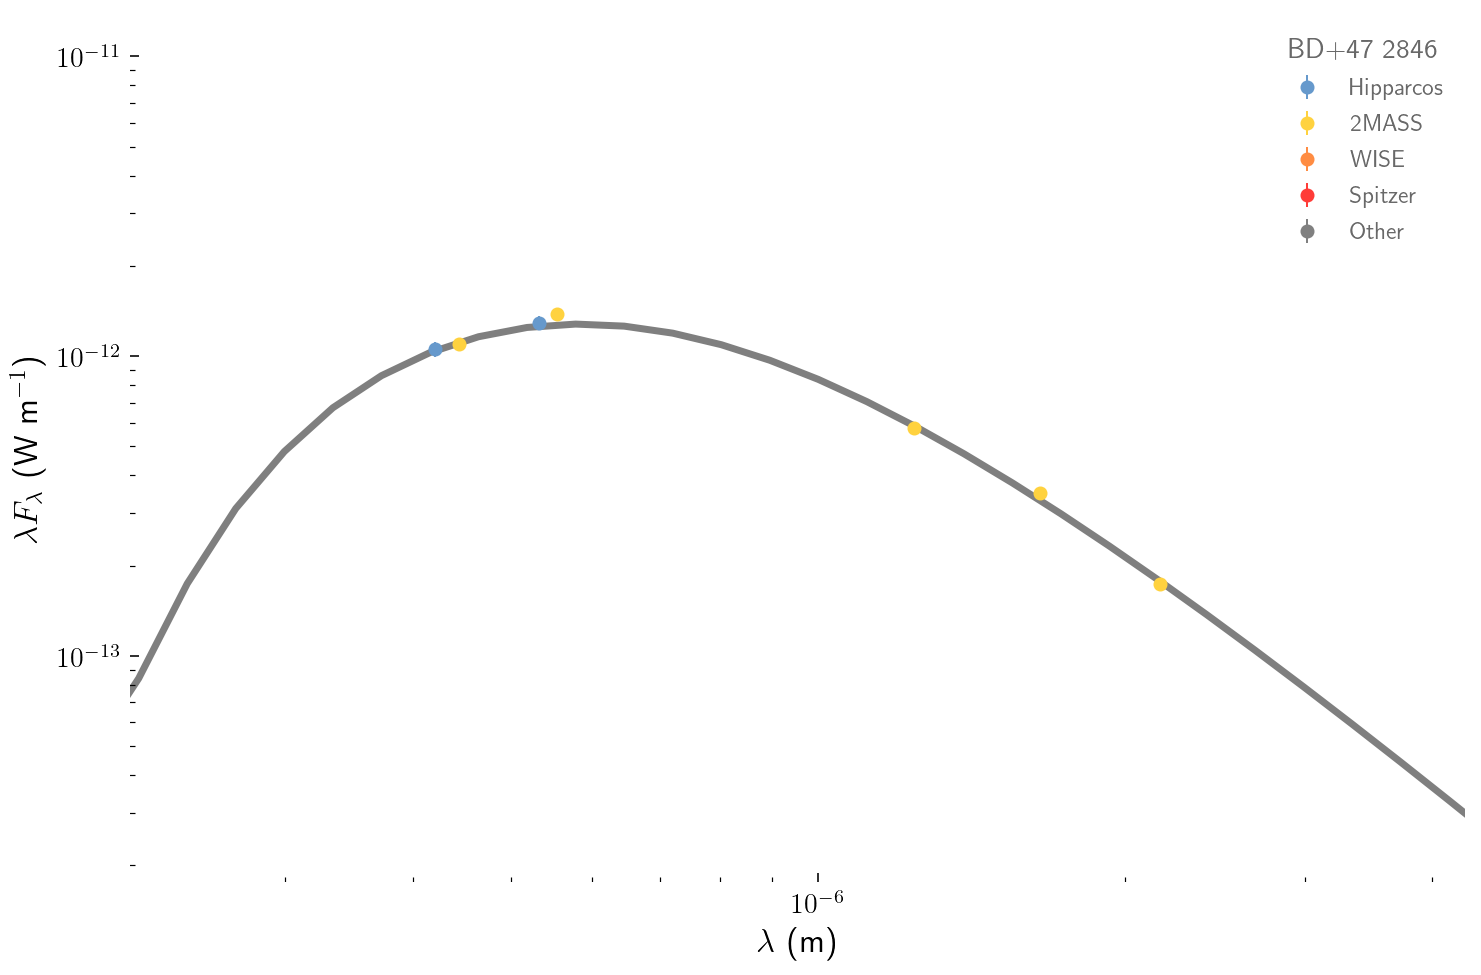

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TableReplaceWarning: replaced column 'error' which looks like an array slice. The new column no longer shares memory with the original array.


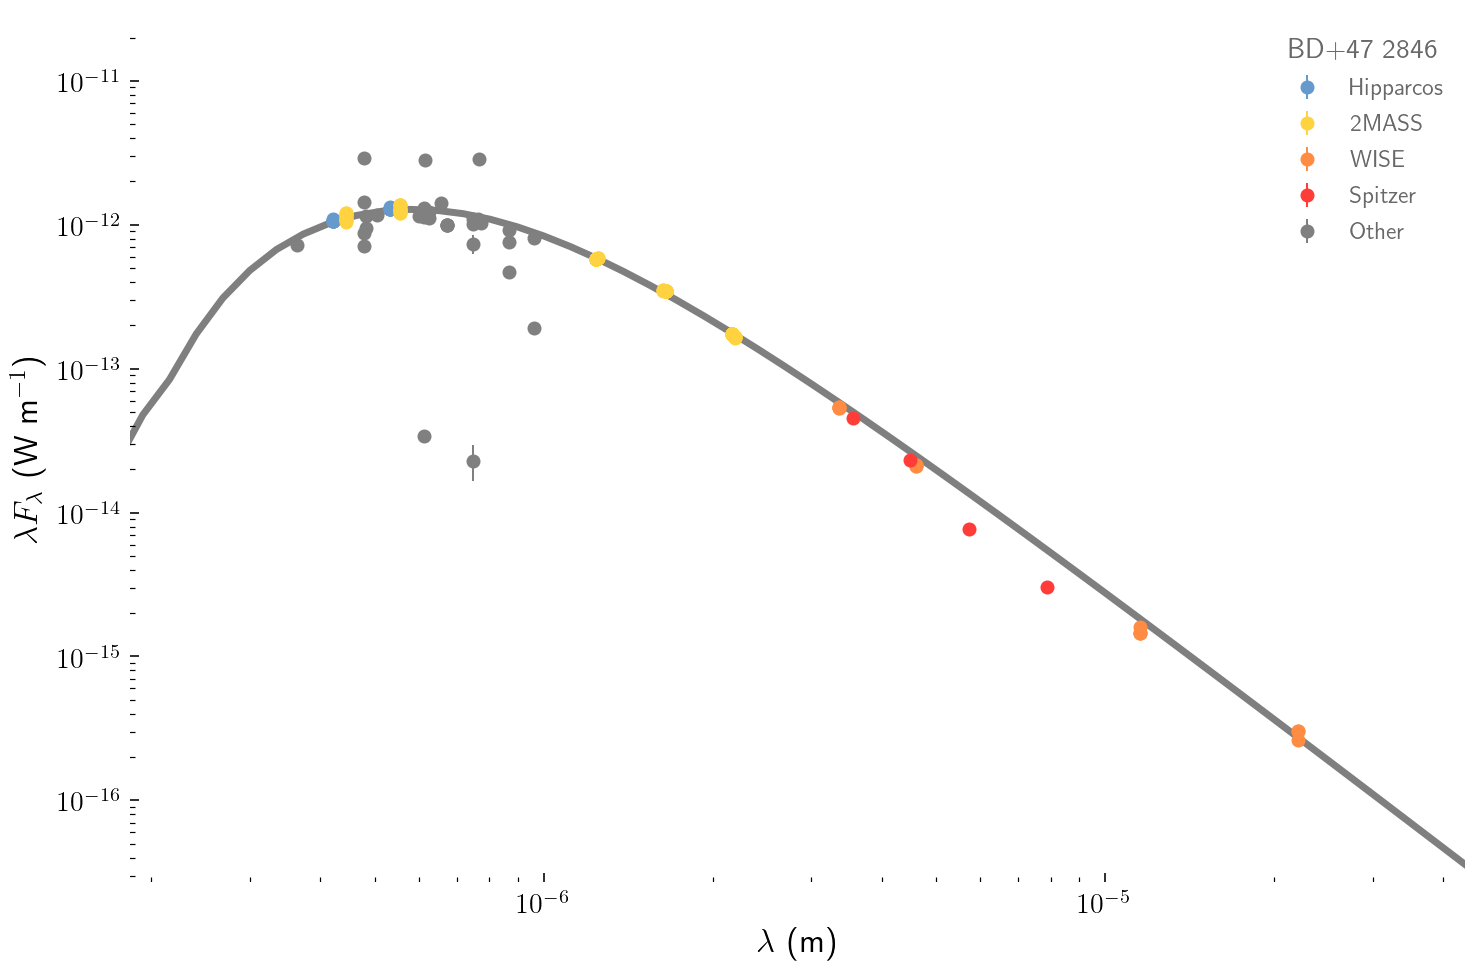

In [156]:
bestProb=np.max(sampler.lnprobability)
print('bestProb: ',bestProb)
bestStep=np.argmax(sampler.lnprobability)
bestX=sampler.chain.reshape((-1, ndim))[bestStep,:]
bestMap=mapXs(bestX)
print('bestMap: ',bestMap)

T0=10**bestMap[0]
L0=10**bestMap[1]
Av=bestMap[2]
sigmaFactor=10**bestMap[3]

modelLs=10**np.linspace(-7,-4,64)
modelFs=oneBlackbody(modelLs,T0,L0,Av)

cleanFig=plt.figure(figsize=(12,8))
cleanPlot=plt.gca()
newRed=redTable[:]
newRed['error']=np.sqrt((newRed['error']**2 + (sigmaFactor*newRed['flux'])**2))
#goodData=np.flatnonzero((cleanTable['telescope']!='INT') | (cleanTable['lambda']<4e-7)) # some dodgy INT points but the lowest wavelength one is useful
#cleanTable=cleanTable[goodData]
SEDBuilder.plotSED(cleanPlot,newRed,telescopes=tels)
cleanPlot.plot(modelLs,modelLs*modelFs,c='k',alpha=0.5)
plt.show()

sedFig=plt.figure(figsize=(12,8))
sedPlot=plt.gca()
newSED=table[:]
newSED['error']=np.sqrt((newSED['error']**2 + (sigmaFactor*newSED['flux'])**2))
SEDBuilder.plotSED(sedPlot,newSED,telescopes=tels)
sedPlot.plot(modelLs,modelLs*modelFs,c='k',alpha=0.5)
plt.show()